In [2]:
# Subsetting Data to 5000 Most Variable Genes

import pandas as pd

# Load expression data (assuming it's a CSV file)
expression_data = pd.read_csv('SRP158491_normalized_logscaled_std_sorted.csv', index_col=0)

# Transpose the data so that rows represent genes and columns represent samples
expression_data = expression_data.T

# Load metadata (TSV file)
metadata = pd.read_csv('metadata_SRP158491.tsv', sep='\t')

# Check if the gene names (index) are unique
if not expression_data.index.is_unique:
    print("There are duplicate gene names.")
    
    # Identify and print duplicate gene names
    duplicates = expression_data.index[expression_data.index.duplicated()]
    print(f"Number of duplicate gene names: {len(duplicates)}")
    
    # Drop duplicates, keeping the first occurrence
    expression_data = expression_data.loc[~expression_data.index.duplicated(keep='first')]

# Confirm that gene names are now unique
print("Gene names unique:", expression_data.index.is_unique)

# Display the first few rows of both dataframes
print(expression_data.shape)  # Now should print (31644, 119) after transpose
print(metadata.shape)

# Calculate standard deviation for each gene (across samples)
gene_variability = expression_data.std(axis=1)

# Print a summary of gene variability
print(gene_variability.describe())

# Sort genes by variability and select the top 5,000 most variable genes
most_variable_genes = gene_variability.nlargest(5000)

# Subset the expression data to the top 5,000 most variable genes
subset_expression_data = expression_data.loc[most_variable_genes.index]

# Print the shape of the subsetted data to confirm
print(f"Subsetted data shape: {subset_expression_data.shape}")  # Should now be (5000, 119)


Gene names unique: True
(31644, 119)
(276, 24)
count    31644.000000
mean         0.434942
std          0.425735
min          0.000000
25%          0.000000
50%          0.390155
75%          0.704094
max          3.798165
dtype: float64
Subsetted data shape: (5000, 119)


Filtered metadata size: (119, 24)
Subsetted expression data size: (119, 5000)


/var/folders/_n/x15p9qy16xl4zd25x_0hgh600000gn/T/ipykernel_91740/3349066824.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata['spectral_cluster'] = spectral_labels


  refinebio_accession_code refinebio_disease  spectral_cluster
0               SRR7725764           healthy                 0
1               SRR7725765           healthy                 0
2               SRR7725767           healthy                 0
3               SRR7725768           healthy                 0
4               SRR7725770           healthy                 1


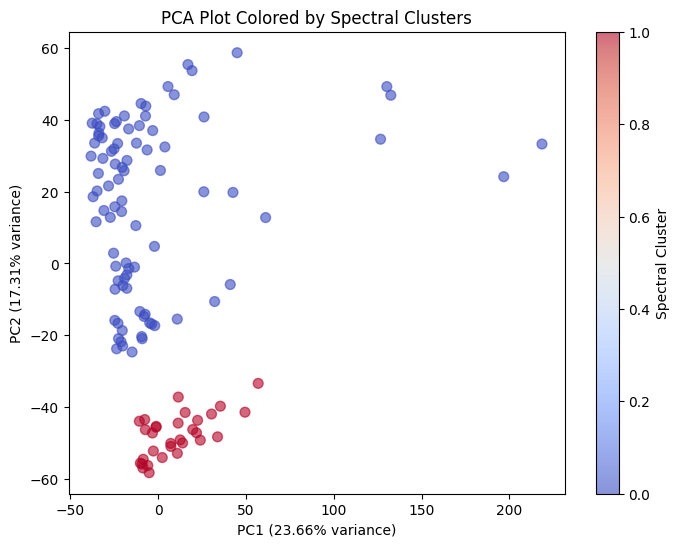

In [3]:
# Running Spectral Clustering with k = 2

from sklearn.cluster import SpectralClustering
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Transpose the data so that rows represent samples and columns represent genes
subset_expression_data_T = subset_expression_data.T

# Step 1: Filter the metadata to only include samples present in subset_expression_data_T
# Assuming that 'refinebio_accession_code' contains the sample IDs
filtered_metadata = metadata[metadata['refinebio_accession_code'].isin(subset_expression_data_T.index)]

# Ensure that the number of rows in filtered_metadata matches the number of samples in the expression data
print(f"Filtered metadata size: {filtered_metadata.shape}")
print(f"Subsetted expression data size: {subset_expression_data_T.shape}")

# Step 2: Run Spectral Clustering with 2 clusters
spectral_clustering = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)

# Fit the spectral clustering model and predict cluster labels
spectral_labels = spectral_clustering.fit_predict(subset_expression_data_T)

# Step 3: Add the spectral cluster labels to the filtered metadata
filtered_metadata['spectral_cluster'] = spectral_labels

# Print the first few rows of metadata with cluster labels
print(filtered_metadata[['refinebio_accession_code', 'refinebio_disease', 'spectral_cluster']].head())

# Step 4: Visualize the clustering using PCA (optional, for 2D visualization)
pca = PCA(n_components=2)
pca_results = pca.fit_transform(subset_expression_data_T)

# Plot the PCA results, colored by spectral cluster labels
plt.figure(figsize=(8, 6))
plt.scatter(pca_results[:, 0], pca_results[:, 1], c=spectral_labels, cmap='coolwarm', s=50, alpha=0.6)
plt.title('PCA Plot Colored by Spectral Clusters')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.colorbar(label='Spectral Cluster')
plt.show()


In [4]:
# Running Spectral Clustering with different k-values

from sklearn.cluster import SpectralClustering
import pandas as pd

# Define a function to run spectral clustering with different values of k
def run_spectral_clustering(data, n_clusters):
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    labels = spectral_clustering.fit_predict(data)
    return labels

# Try different values of k (e.g., 2, 3, 4, 5)
for k in [2, 3, 4, 5]:
    print(f"\nRunning Spectral Clustering with {k} clusters")
    cluster_labels = run_spectral_clustering(subset_expression_data.T, n_clusters=k)
    
    # Add the cluster labels to the filtered metadata
    filtered_metadata[f'spectral_cluster_{k}'] = cluster_labels
    
    # Check the distribution of clusters and how they align with disease status
    print(filtered_metadata.groupby(f'spectral_cluster_{k}')['refinebio_disease'].value_counts())



Running Spectral Clustering with 2 clusters


/var/folders/_n/x15p9qy16xl4zd25x_0hgh600000gn/T/ipykernel_91740/3702931198.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata[f'spectral_cluster_{k}'] = cluster_labels
/var/folders/_n/x15p9qy16xl4zd25x_0hgh600000gn/T/ipykernel_91740/3702931198.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata[f'spectral_cluster_{k}'] = cluster_labels


spectral_cluster_2  refinebio_disease
0                   healthy              47
                    ra non treatment     41
1                   ra non treatment     16
                    healthy              15
Name: count, dtype: int64

Running Spectral Clustering with 3 clusters
spectral_cluster_3  refinebio_disease
0                   healthy              29
                    ra non treatment     19
1                   ra non treatment     22
                    healthy              18
2                   ra non treatment     16
                    healthy              15
Name: count, dtype: int64

Running Spectral Clustering with 4 clusters
spectral_cluster_4  refinebio_disease
0                   healthy              24
                    ra non treatment     14
1                   healthy              13
                    ra non treatment     13
2                   ra non treatment     16
                    healthy              15
3                   ra non treatment    

/var/folders/_n/x15p9qy16xl4zd25x_0hgh600000gn/T/ipykernel_91740/3702931198.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata[f'spectral_cluster_{k}'] = cluster_labels
/var/folders/_n/x15p9qy16xl4zd25x_0hgh600000gn/T/ipykernel_91740/3702931198.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata[f'spectral_cluster_{k}'] = cluster_labels


In [5]:
# Rerunning Clustering with Different Numbers of Genes

from sklearn.cluster import SpectralClustering
import pandas as pd
from sklearn.metrics import silhouette_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

# Function to select top N variable genes and perform spectral clustering
def run_clustering_with_n_genes(expression_data, n_genes, n_clusters=2):
    # Calculate standard deviation for each gene (across samples)
    gene_variability = expression_data.std(axis=1)
    
    # Select the top N most variable genes
    most_variable_genes = gene_variability.nlargest(n_genes)
    
    # Subset the expression data to the top N most variable genes
    subset_expression_data = expression_data.loc[most_variable_genes.index]
    
    # Transpose the data so that rows represent samples and columns represent genes
    subset_expression_data_T = subset_expression_data.T
    
    # Run spectral clustering
    spectral_clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=42)
    labels = spectral_clustering.fit_predict(subset_expression_data_T)
    
    return labels

# Run clustering with different numbers of genes
labels_10 = run_clustering_with_n_genes(subset_expression_data, 10)
labels_100 = run_clustering_with_n_genes(subset_expression_data, 100)
labels_1000 = run_clustering_with_n_genes(subset_expression_data, 1000)
labels_10000 = run_clustering_with_n_genes(subset_expression_data, 10000)

# Add cluster labels to metadata for comparison
filtered_metadata['cluster_10_genes'] = labels_10
filtered_metadata['cluster_100_genes'] = labels_100
filtered_metadata['cluster_1000_genes'] = labels_1000
filtered_metadata['cluster_10000_genes'] = labels_10000



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/var/folders/_n/x15p9qy16xl4zd25x_0hgh600000gn/T/ipykernel_91740/3427590251.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_metadata['cluster_10_genes'] = labels_10
/var/folders/_n/x15p9qy16xl4zd25x_0hgh600000gn/T/ipykernel_91740/3427590251.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returni

In [6]:
# Performing a Chi-Squared Test on Each Pair of Clustering Results

# Function to perform chi-squared test on two clustering results
def chi_squared_test(cluster_labels_1, cluster_labels_2):
    contingency_table = pd.crosstab(cluster_labels_1, cluster_labels_2)
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    return chi2, p_value

# Perform chi-squared tests between different clustering results
chi2_10_vs_100, p_value_10_vs_100 = chi_squared_test(labels_10, labels_100)
chi2_100_vs_1000, p_value_100_vs_1000 = chi_squared_test(labels_100, labels_1000)
chi2_1000_vs_10000, p_value_1000_vs_10000 = chi_squared_test(labels_1000, labels_10000)

# Print the chi-squared test results
print(f"Chi-squared test between 10 and 100 genes: chi2 = {chi2_10_vs_100}, p-value = {p_value_10_vs_100}")
print(f"Chi-squared test between 100 and 1000 genes: chi2 = {chi2_100_vs_1000}, p-value = {p_value_100_vs_1000}")
print(f"Chi-squared test between 1000 and 10000 genes: chi2 = {chi2_1000_vs_10000}, p-value = {p_value_1000_vs_10000}")


Chi-squared test between 10 and 100 genes: chi2 = 22.943588251215974, p-value = 1.66825719153035e-06
Chi-squared test between 100 and 1000 genes: chi2 = 47.52379562268675, p-value = 5.434030739940273e-12
Chi-squared test between 1000 and 10000 genes: chi2 = 113.86562746574033, p-value = 1.394450569291927e-26


In [7]:
# Creating a Sankey Plot 

import plotly.graph_objects as go

# Prepare data for the Sankey plot
labels = ["Cluster 1 (10 genes)", "Cluster 2 (10 genes)",
          "Cluster 1 (100 genes)", "Cluster 2 (100 genes)",
          "Cluster 1 (1000 genes)", "Cluster 2 (1000 genes)",
          "Cluster 1 (10000 genes)", "Cluster 2 (10000 genes)"]

# Get the counts of samples in each cluster for each gene set
cluster_10_counts = pd.Series(labels_10).value_counts()
cluster_100_counts = pd.Series(labels_100).value_counts()
cluster_1000_counts = pd.Series(labels_1000).value_counts()
cluster_10000_counts = pd.Series(labels_10000).value_counts()

# Create Sankey plot
fig = go.Figure(go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color="blue"
    ),
    link=dict(
        source=[0, 1, 2, 3, 4, 5],  # source nodes (clusters)
        target=[2, 3, 4, 5, 6, 7],  # target nodes (next cluster)
        value=[cluster_10_counts[0], cluster_10_counts[1],
               cluster_100_counts[0], cluster_100_counts[1],
               cluster_1000_counts[0], cluster_1000_counts[1]]
    )
))

# Update layout for better readability
fig.update_layout(title_text="Alluvial Diagram of Clustering Results", font_size=10)

# Show plot
fig.show()



